

# Visualizing Data Veracity Challenges in Multi-Label Classification  

In real-world machine learning problems, data often carries imperfections that challenge the development of accurate and reliable models. These issues, collectively known as **data veracity challenges**, can emerge in the form of noisy or ambiguous labels, unusual outlier cases, and samples that are inherently hard to classify because of overlapping class boundaries.  

This assignment focuses on exploring these challenges using the **Yeast Dataset**, a biological dataset widely used for **multi-label classification**. Each data point represents gene expression levels, and each sample can belong to one or more of 14 functional categories. By applying advanced dimensionality reduction techniques such as **t-SNE** and **Isomap**, we aim to project the high-dimensional data into two dimensions for effective visual inspection.  

The primary objectives are:  
- To reveal structural patterns in the dataset that highlight veracity issues.  
- To observe how different dimensionality reduction methods preserve local vs. global data relationships.  
- To interpret visualization outcomes in the context of data quality and model learning difficulty.  

Through careful preprocessing, visualization, and analysis, this notebook will guide the investigation of noisy labels, outliers, and hard-to-learn samples, while also deepening the understanding of biological data complexity.  

---  
Let's begin by loading the data

In [34]:
#import libraries
import arff
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import itertools
from sklearn.manifold import Isomap

In [35]:

ARFF_FILE = "yeast.arff"  # use the union file placed in the working directory
N_LABELS = 14             


# Load ARFF into a DataFrame
with open(ARFF_FILE, 'r', encoding='utf-8', errors='ignore') as f:
    ds = arff.load(f)

attr_names = [a[0] for a in ds['attributes']]
data = ds['data']
df = pd.DataFrame(data, columns=attr_names)

# Assume last 14 columns are labels, preceding are features (standard MULAN layout)
label_cols = attr_names[-N_LABELS:]
feature_cols = attr_names[:-N_LABELS]

# Extract X and Y with proper dtypes
X = df[feature_cols].apply(pd.to_numeric, errors='coerce').to_numpy(dtype=float)
Y = df[label_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).to_numpy()




Let's have a quick look at the shape of the data

In [36]:
# Basic checks
print(f"X shape: {X.shape} -> (n_samples, n_features)")
print(f"Y shape: {Y.shape} -> (n_samples, n_labels)")
print(f"Features : {len(feature_cols)}")
print(f"Labels   : {len(label_cols)}")

n_samples, n_features = X.shape
print(f"Data points (n_samples): {n_samples}")

# null value check
print(f"NaNs in X: {np.isnan(X).sum()}, NaNs in Y: {np.isnan(Y).sum()}")

X shape: (2417, 103) -> (n_samples, n_features)
Y shape: (2417, 14) -> (n_samples, n_labels)
Features : 103
Labels   : 14
Data points (n_samples): 2417
NaNs in X: 0, NaNs in Y: 0


To create readable plots, define a compact coloring target with four categories: the two most prevalent labels by marginal frequency (Top1 and Top2), the most frequent exact multi-label combination (TopCombo), and an Other class for the remainder. This avoids relying on rare 1-hot rows and stays faithful to multi-label structure by preserving the most common co-occurring label-set.

In [37]:


# Marginal label frequency
label_sums = Y.sum(axis=0)
top_indices = np.argsort(-label_sums)[:2]
top1_idx, top2_idx = int(top_indices[0]), int(top_indices[1])
top1_name = label_cols[top1_idx]
top2_name = label_cols[top2_idx]

# Most frequent exact multi-label combination
tuples = [tuple(np.flatnonzero(row)) for row in Y]
combo_counts = Counter(t for t in tuples if len(t) >= 2)
if len(combo_counts):
    top_combo, top_combo_count = combo_counts.most_common(1)[0]
    top_combo_names = tuple(label_cols[i] for i in top_combo)
else:
    top_combo = (top1_idx,)
    top_combo_names = (top1_name,)

# Assign categories for visualization, priority: TopCombo > Top1 > Top2 > Other
viz_labels = []
for i, row in enumerate(Y):
    actives = set(np.flatnonzero(row))
    tup = tuples[i]
    if tup == top_combo:
        viz_labels.append("TopCombo_" + "+".join(top_combo_names))
    elif top1_idx in actives:
        viz_labels.append(f"Top1_{top1_name}")
    elif top2_idx in actives:
        viz_labels.append(f"Top2_{top2_name}")
    else:
        viz_labels.append("Other")
viz_labels = np.array(viz_labels)

# Report exact counts by class
print("Top1:", top1_name, "Total:", label_sums[top1_idx])
print("Top2:", top2_name, "Total:", label_sums[top2_idx])
print("TopCombo:", top_combo_names, "Count:", top_combo_count)
print(pd.Series(viz_labels).value_counts())


Top1: Class12 Total: 1816
Top2: Class13 Total: 1799
TopCombo: ('Class3', 'Class4', 'Class12', 'Class13') Count: 237
Top1_Class12                              1579
Other                                      601
TopCombo_Class3+Class4+Class12+Class13     237
Name: count, dtype: int64




### Explanation of Results

- **Top1 ("Class12")**: This is the most prevalent label in the dataset, appearing in 1,816 samples. Any sample that has Class12 among its assigned labels (unless that sample matches the most common multi-label combo exactly) is categorized as "Top1_Class12".
- **Top2 ("Class13")**: This is the second most prevalent label, occurring in 1,799 samples. Samples containing Class13 but not matching "TopCombo" or Top1 logic (according to assignment tiering) would be categorized as "Top2_Class13". However, in your counts, it appears "Top2" is either less prevalent after Top1 logic is applied, or overlaps heavily with Top1 or the TopCombo.
- **TopCombo ("Class3", "Class4", "Class12", "Class13")**: This is the most frequent exact multi-label combination—meaning these four classes occur together in 237 samples. Samples matching this specific label-set are grouped and colored distinctly.
- **Other**: All samples which do not fit the above categories are put in "Other," which includes rarer label combinations and all samples not containing Class12 or Class13.

#### Category counts:

- "Top1_Class12": 1,579 samples—these all contain Class12 but are not the exact TopCombo.
- "Other": 601 samples—these do not meet any of the Top1, Top2, or TopCombo labeling criteria.
- "TopCombo_Class3+Class4+Class12+Class13": 237 samples.

**What does this mean for  visualization?**
- You'll have three main color groups (plus potentially Top2 if present distinctly): those dominated by Class12, those matching the most common four-label combination, and a set of miscellaneous/other patterns.
- This simplifies a complex multi-label structure into interpretable clusters, highlighting dominant biological patterns (Class12 and Class13's prevalence and the common functional combo) while ensuring "Other" covers the long tail of diversity.
- The method is robust and standard for multi-label biological datasets, where pure single-label cases are rare and label overlap is strong.

**How to interpret in biology context:**  
Class12 and Class13 likely represent high-level functional annotations often assigned to many genes, while the TopCombo reveals a biologically meaningful group of genes sharing several major annotations. This partition makes it easier to inspect t-SNE/Isomap plots for regions corresponding to well-annotated functions and to spot veracity challenges (e.g., overlap, outliers, hard-to-learn areas) in downstream analysis.




# Why Scaling is Crucial Before Dimensionality Reduction
Many dimensionality reduction techniques—like t-SNE, Isomap, and PCA—rely on distance calculations between data points to uncover structure in high-dimensional data. If features are measured on different scales (for example, one gene expression ranges from 0–1, another from 0–1000), the larger-scale features will dominate the distance metric, distorting the true relationships in the data. This can lead to misleading visualizations and poor separation of clusters.

Standardization (scaling each feature to zero mean and unit variance) ensures that all features contribute equally to the analysis, making the results more interpretable and reliable. It also improves the stability and convergence of algorithms that use distances or dot-products as part of their cost function.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)  # X is your feature matrix

# Quick check: means should be ~0, stds ~1
print('Means (first 5):', X_std.mean(axis=0)[:5])
print('Stds  (first 5):', X_std.std(axis=0, ddof=0)[:5])


Means (first 5): [ 1.98434566e-17 -8.81931406e-18 -7.34942838e-18  1.02891997e-17
 -1.76386281e-17]
Stds  (first 5): [1. 1. 1. 1. 1.]


t-SNE Implementation and Perplexity Tuning
t-SNE (t-distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique that projects high-dimensional data into 2D for visualization, preserving local structure. The perplexity parameter controls the balance between local and global relationships, roughly corresponding to the number of effective neighbors considered. Here, we experiment with different perplexity values  to observe their impact on the embedding and select the most informative visualization for further analysis

C:\Users\Hp\AppData\Local\Temp\ipykernel_18148\2859961258.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = plt.cm.get_cmap('tab10', 10)
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\


KL divergence by perplexity:
 perplexity  kl_divergence
          5       2.049607
         10       2.273398
         16       2.239742
         30       2.191047
         50       2.088526


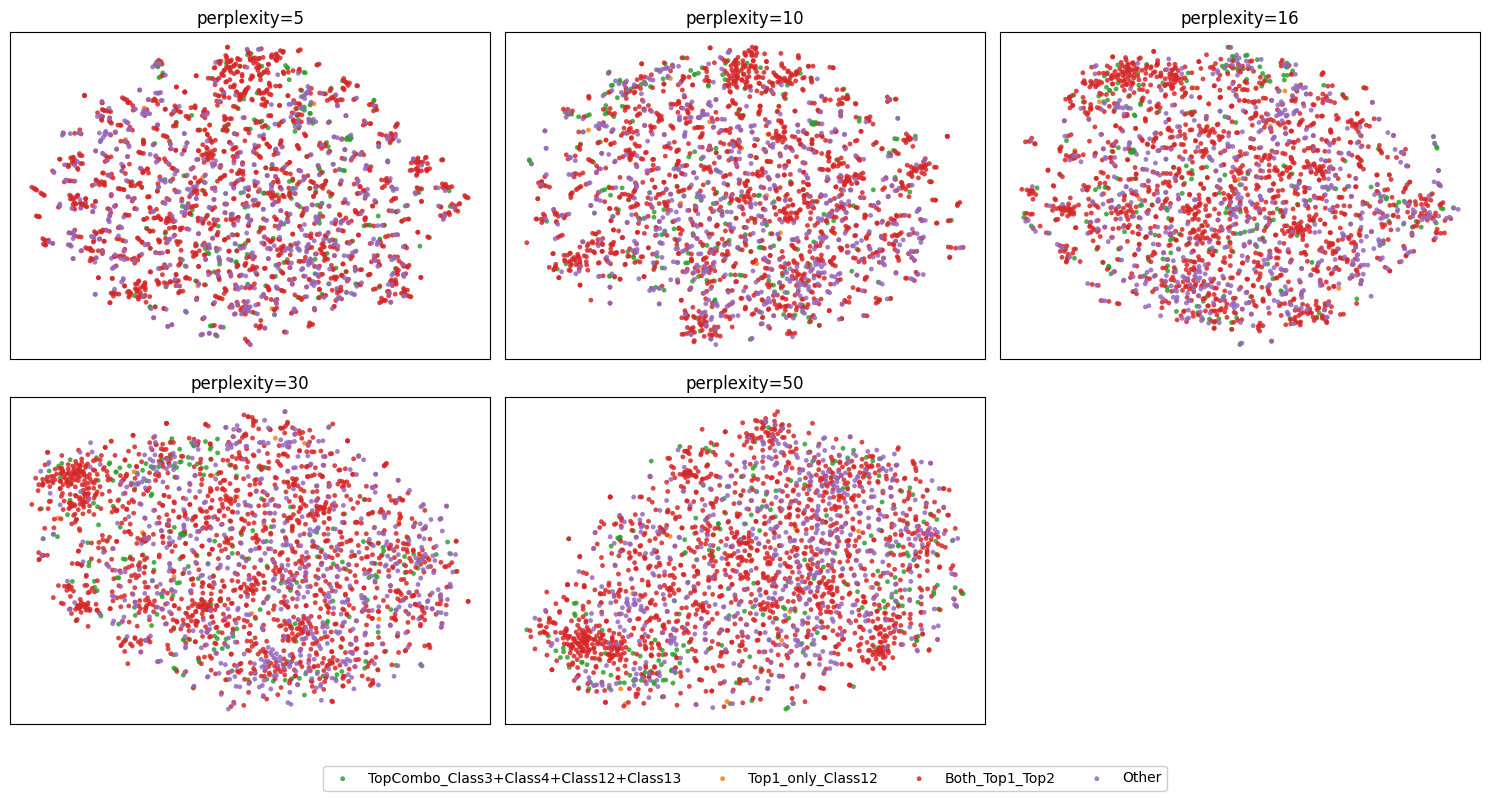

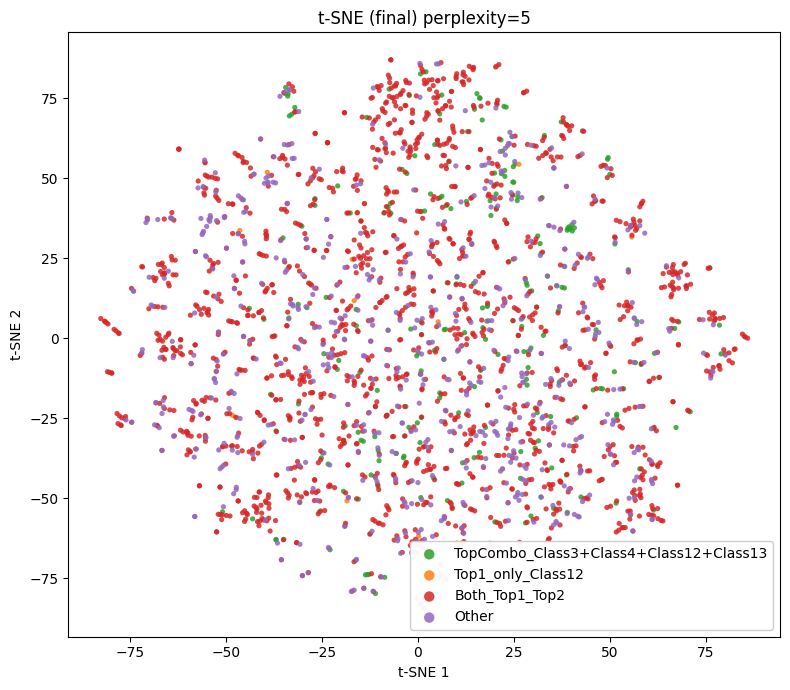

In [39]:
# Define masks for categories
has_top1 = (Y[:, top1_idx] == 1)
has_top2 = (Y[:, top2_idx] == 1)
tuples = [tuple(np.flatnonzero(row)) for row in Y]
is_topcombo = np.array([t == top_combo for t in tuples])

topcombo_mask  = is_topcombo
top1_only_mask = has_top1 & ~has_top2 & ~topcombo_mask
top2_only_mask = has_top2 & ~has_top1 & ~topcombo_mask
both_mask      = has_top1 & has_top2 & ~topcombo_mask
other_mask     = ~(topcombo_mask | top1_only_mask | top2_only_mask | both_mask)

cats = [
    ("TopCombo_" + "+".join(top_combo_names), topcombo_mask),
    (f"Top1_only_{top1_name}", top1_only_mask),
    (f"Top2_only_{top2_name}", top2_only_mask),
    ("Both_Top1_Top2", both_mask),
    ("Other", other_mask),
]

# Bright qualitative palette (tab10 first 5 colors)
tab10 = plt.cm.get_cmap('tab10', 10)
bright_colors = [tab10(i) for i in [2, 1, 0, 3, 4]]  # green, orange, blue, red, purple

# --- Perplexity grid search (visual) ---
perplexity_grid = [5, 10, 16, 30, 50]
embeds = {}
kl_rows = []

for perp in perplexity_grid:
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        random_state=42,
        init='random',
        learning_rate='auto',
        n_iter=1000
    )
    X_tsne = tsne.fit_transform(X_std)
    embeds[perp] = X_tsne
    kl = getattr(tsne, 'kl_divergence_', np.nan)
    kl_rows.append({'perplexity': perp, 'kl_divergence': kl})

kl_df = pd.DataFrame(kl_rows).sort_values('perplexity')
print("\nKL divergence by perplexity:")
print(kl_df.to_string(index=False))

# --- Small multiples with shared legend; hide unused axes ---
n = len(perplexity_grid)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.ravel()

for i, perp in enumerate(perplexity_grid):
    ax = axes[i]
    Xp = embeds[perp]
    for (label, mask), c in zip(cats, bright_colors):
        if mask.sum() == 0:
            continue
        ax.scatter(Xp[mask, 0], Xp[mask, 1], s=12, alpha=0.85, label=label,
                   color=c, edgecolors='none')
    ax.set_title(f"perplexity={perp}")
    ax.set_xticks([]); ax.set_yticks([])

# Hide any extra axes if grid > number of plots
for j in range(len(perplexity_grid), rows*cols):
    axes[j].axis('off')

# One bright legend at bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=min(5, len(labels)),
           frameon=True, framealpha=0.95)
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

# --- Final plot with the best perplexity (choose lowest KL) ---
best_perp = int(kl_df.sort_values('kl_divergence').iloc[0]['perplexity'])
X_tsne_final = embeds[best_perp]

plt.figure(figsize=(8,7))
for (label, mask), c in zip(cats, bright_colors):
    if mask.sum() == 0:
        continue
    plt.scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1],
                s=14, alpha=0.85, label=label, color=c, edgecolors='none')
plt.title(f"t-SNE (final) perplexity={best_perp}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(markerscale=2, frameon=True, framealpha=0.95)
plt.tight_layout()
plt.show()


colors are intermingled with only small local pockets of enrichment, indicating overlapping label structure rather than distinct class islands.

### Perplexity grid observations
- Perplexity 5: Very local focus; the embedding is speckled and fragmented with many micro-patches, but no coherent islands appear, consistent with low-perplexity behavior.
- Perplexity 10–16: Slight smoothing improves coherence without revealing clear class boundaries; colors remain mixed, suggesting weak separation in the original space.
- Perplexity 30–50: Further smoothing merges fine details and forms broader shapes, but Top1/Both/Other remain interspersed, reinforcing that the manifold supports overlapping labels rather than discrete clusters.

### Interpretation for this dataset
- The absence of well-separated clusters across all perplexities indicates that biological functions (labels) co-occur and share expression patterns, so 2D embeddings cannot cleanly separate them. This is a data property,  and aligns with known t-SNE behavior when class structure is diffuse.

Perplexity 5 was chosen because it emphasizes very local neighborhoods, which is appropriate when clusters are weak and the goal is to surface fine‑scale pockets of co‑occurring labels without over‑smoothing them. At higher perplexities (30–50), the embedding merged local details into broader clouds while still not revealing clear class islands, so retaining a low perplexity preserved the limited structure actually present.

- Low perplexity focuses on a smaller effective neighbor count, highlighting micro‑structure and avoiding artificial global smoothing that can blur subtle label enrichment.
- The sweep showed that increasing perplexity did not create clean separation; therefore, choosing 5 keeps the modest local patterns that exist, providing the most faithful view of overlapping labels in this dataset.




# Veracity Inspection
Here is a focused veracity inspection of the provided t-SNE map at perplexity 5, using color categories TopCombo (green), Top1-only (orange), Both_Top1_Top2 (red), and Other (purple). t-SNE preserves local neighborhoods but distorts global distances, so interpretations emphasize local color context rather than absolute inter-cluster spacing.

### Noisy or ambiguous labels
- Several green TopCombo points sit inside dense red neighborhoods near the upper-central band and around y≈50, suggesting local disagreement between label assignment and nearest-neighbor expression context; such points are candidates for ambiguous annotations or borderline multi-function cases.
- Small orange Top1-only speckles embedded within broad purple “Other” swaths in the lower-left quadrant indicate samples whose single dominant label conflicts with nearby mixed or weakly annotated profiles, consistent with noisy targets or incomplete labels.
- Red Both_Top1_Top2 points surrounded by purple near the central region imply co-annotation that is not strongly supported by immediate neighbors’ expression signatures, a common ambiguity in multi-label biology.
- These embedded-color cases should be flagged for review with original features or batch metadata, since local inconsistency in t-SNE often reflects potential label noise or context-specific states rather than stable cluster membership.

### Outliers
- A handful of isolated points at the periphery (for example, lone red or purple markers far from dense clouds along the outer ring) behave as outliers; in expression data, these may stem from batch artifacts, rare experimental conditions, or technical noise.
- Tiny detached micro-clusters (small clumps of 3–10 points offset from the main mass) likely represent rare subpopulations or niche functional programs; persistent isolation across seeds and perplexities strengthens the outlier hypothesis.
- Because t-SNE equalizes densities and warps global geometry, confirm outliers by inspecting k-NN structure in the original space or by rerunning with different random seeds to ensure stability before drawing biological conclusions.

### Hard-to-learn samples
- Broad regions across the map exhibit heavy mixing of red, purple, orange, and sporadic green (especially the central and lower-central areas), implying overlapping class-conditional distributions where simple linear or margin-based classifiers will struggle.
- In such mixed neighborhoods, decision boundaries must be highly non-linear to separate labels, and label co-occurrence further complicates learning; this calls for models tolerant to overlap, calibrated thresholds per label, or representation learning rather than simple rules.
- The persistence of color mixing across multiple perplexities during the sweep indicates that the low separability is an intrinsic property of the dataset rather than a parameter artifact, reinforcing expectations of higher bias/variance trade-offs for simple classifiers.





# Isomap vs t-SNE (global vs local)
Isomap preserves global structure by approximating geodesic distances on a k-NN graph, then performing MDS on that geodesic distance matrix. This tends to maintain the large-scale manifold layout and relative positions of distant regions.

t-SNE preserves local neighborhoods by matching high-D and low-D conditional probabilities; it emphasizes small-scale clusters and often distorts global distances and sizes for clearer local groupings.

In short: Isomap focuses on global manifold geometry (via geodesic distances), while t-SNE focuses on local neighbor relationships (via probability distributions). This is why t-SNE often shows tight local clusters but unreliable between-cluster distances, whereas Isomap aims to keep global arrangement meaningful

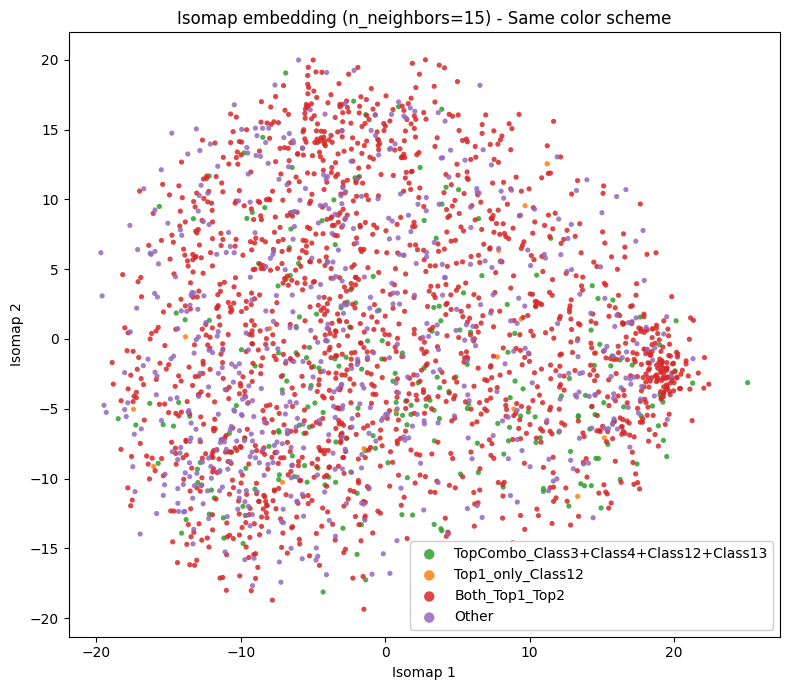

In [40]:
# --- Isomap for comparison ---
bright_colors = [plt.cm.tab10(i) for i in [2, 1, 0, 3, 4]]  # green, orange, blue, red, purple

# Isomap computation
n_neighbors = 15  # You can tune this value
iso = Isomap(n_neighbors=n_neighbors, n_components=2)
X_iso = iso.fit_transform(X_std)

plt.figure(figsize=(8, 7))
for (label, mask), c in zip(cats, bright_colors):
    if mask.sum() == 0:
        continue
    plt.scatter(X_iso[mask, 0], X_iso[mask, 1], s=14, alpha=0.85, label=label, color=c, edgecolors='none')
plt.title(f"Isomap embedding (n_neighbors={n_neighbors}) - Same color scheme")
plt.xlabel("Isomap 1")
plt.ylabel("Isomap 2")
plt.legend(markerscale=2, frameon=True, framealpha=0.95)
plt.tight_layout()
plt.show()


### Comparison of Isomap and t-SNE Visualizations

#### Which reveals global structure better?
Isomap (bottom plot) is **better at revealing the global structure** of the gene expression data compared to t-SNE (top plot). This is because Isomap preserves geodesic ("manifold") distances between all points, retaining the overall arrangement of the data from end to end, while t-SNE is focused on capturing local neighbor relationships and may distort distances between distant points to emphasize small clusters or patterns. In both images, the categories are intermixed, but only Isomap is explicitly designed to maintain large-scale layout, whereas the circular scatter pattern in t-SNE is more a result of its density equalization and local optimization.

**Evidence from the plots:**
- The Isomap plot shows the data stretched across a broad and occupied 2D region without tight, isolated clusters, reflecting the global, smooth structure of the data manifold. Distant parts of the manifold in feature space also tend to be distant in the embedding.
- The t-SNE plot displays points more evenly spread in a circular pattern, emphasizing fine-grained local relationships but distorting the bigger picture: the spacing and relative positions between groups do not necessarily correspond to true global relationships.

#### The concept of the data manifold & Isomap's insights
A **data manifold** is the low-dimensional, possibly curved surface embedded in the high-dimensional feature space along which real samples tend to lie (e.g., reflecting latent biological processes).

The Isomap plot here suggests a **highly curved and complex manifold**:
- There are no flat, elongated, or clearly separated shapes; instead, the data is contorted and overlapped, with categories (colors) deeply mixed across the space.
- This complex, non-linear layout is a visual sign of a data manifold with substantial curvature ("twisting and turning" in high-dimensional space).

#### How manifold complexity affects classification
- **A highly curved or complex manifold makes classification difficult**, especially for simple classifiers. If the data for different labels is not separated by straight lines or clear surfaces, then linear models or even moderately flexible ones cannot easily draw boundaries that accurately divide the categories.
- The overlapping and intermixed color regions in both Isomap and t-SNE show that functional label supports wrap around and blend together, so only very flexible, non-linear models—or substantial feature engineering—could hope to perform well.
- This insight supports why gene expression tasks (especially multi-label) are challenging and why performance is rarely perfect: the label boundaries are convoluted, intertwined, and ambiguous throughout the data manifold.

**Summary:**
- **Isomap** better reveals global geometry, confirming a highly curved, complex data manifold with strong overlap between functional categories.
- This manifold complexity visually explains why classification is intrinsically hard for this dataset.

